C'est ici que toute la documentation du pipeline, les résultats et les analyses visuelles sont intégrés.

Ce notebook contient les explications et appelle les scripts du dossier src/ pour exécuter chaque étape du pipeline.

On l'utilise pour charger et exécuter le pipeline étape par étape. 

Par exemple, pour exécuter la partie nettoyage, importer et exécuter data_preprocessing.py depuis src/.

À chaque étape (nettoyage, analyse des données, visualisations), ajouter des cellules Markdown dans le notebook pour expliquer ce que fait chaque étape, pourquoi elle est nécessaire, et les observations tirées des résultats.

C’est également ici que nous ajouterons les graphiques et analyses visuelles pour expliquer nos résultats intermédiaires.

Expliquer ce que l'on fait dans notre projet et que pour ce faire nous utiliserons une version clean de movie_metadata.
On affiche à partir de quelle année notre base de données de films commence pour exclure les évènements historiques trop lointains dans notre dataset additionnel.
On veut garder la première colonne pour relier le film à son résumé mais aussi la plupart des autres.
On veut transformer les formats de dates pour l’analyse temporelle.

In [143]:
from tests.test_data_preprocessing import test_cleaned_movie_data
import matplotlib.pyplot as plt 
import pandas as pd
import ast
import numpy as np

In [144]:
movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas
len(movies_data)

81741

In [145]:
movies_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Open the preprocessed dataset, ready for analysis. 
Expliquer les détails du preprocessing ici !


In [146]:
preprocessed_movies = pd.read_csv("data\Preprocessed_data\preprocessed_movie_metadata.csv")
len(preprocessed_movies)

8323

In [147]:
preprocessed_movies.head()

,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
1,Alexander's Ragtime Band,3600000.0,106.0,English Language,United States of America,"Musical, Comedy, Black-and-white",1938.0
2,Henry V,10161099.0,137.0,English Language,United Kingdom,"Costume drama, War film, Epic, Period piece, D...",1989.0
3,Mary Poppins,102272727.0,139.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",1964.0
4,New Rose Hotel,21521.0,92.0,English Language,United States of America,"Thriller, Science Fiction, Future noir, Indie,...",1999.0


#### Number of film of year

It is important to note for our future analysis that the number of films produced each year is not uniform. This variability should be considered when comparing film counts over time. In some cases, working with proportions rather than absolute numbers may provide us more interesting insights.


Text(0.5, 1.0, 'Number of movies per year')

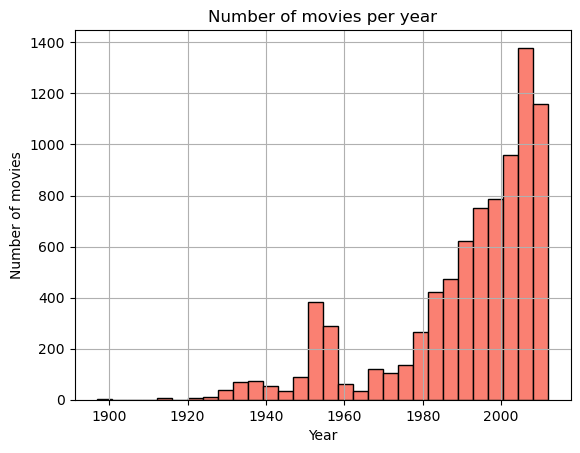

In [148]:
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")

# Genre Movie exploring

In [149]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Movie genres'].str.split(', ').explode().unique()
print(len(genres),genres)

311 ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Musical' 'Comedy' 'Black-and-white' 'Costume drama'
 'War film' 'Epic' 'Period piece' 'Drama' 'Film adaptation'
 "Children's/Family" 'Fantasy' 'Family Film' "Children's Fantasy"
 'Future noir' 'Indie' 'Erotic thriller' 'Crime Fiction' 'Coming of age'
 'Romance Film' 'Marriage Drama' 'Action/Adventure' 'World cinema' 'Cult'
 'Adventure Comedy' 'Slapstick' 'Sports' 'Family Drama' 'Comedy-drama'
 'Ensemble Film' 'Romantic comedy' 'Short Film' 'Epic Western' 'Western'
 'Silent film' 'Mystery' 'Crime Thriller' 'Satire' 'Legal drama'
 'Courtroom Drama' 'New Hollywood' 'Suspense' 'Romantic drama' 'Biography'
 'Biopic [feature]' 'Biographical film' 'Musical Drama' 'Crime Comedy'
 'Gangster Film' 'Monster movie' 'Natural horror films' 'B-movie'
 'Creature Film' 'Slasher' 'Music' 'Comedy of Errors' 'Americana' 'LGBT'
 'Teen' 'Escape Film' 'Prison' 'Superhero movie' 'Wuxia'
 'Fantasy Adventure' 'Marti

There are 363 different genres, many genres are used to described the film. Here a genre regroup a lot of information: the thematic, the technical characteristics, ... 
Clearly, not all of these information are useful for our analysis. We need to select to best to regroup the film in a meaningful way.

## Petite tentative pour observer les war movies

In [150]:
War_movies = preprocessed_movies[preprocessed_movies['Movie genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Movie genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Movie genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

418 57 340


Text(0.5, 1.0, 'Number of movies per year')

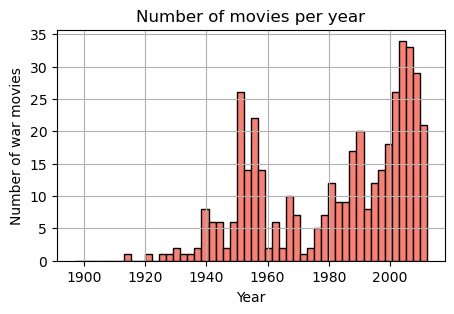

In [151]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

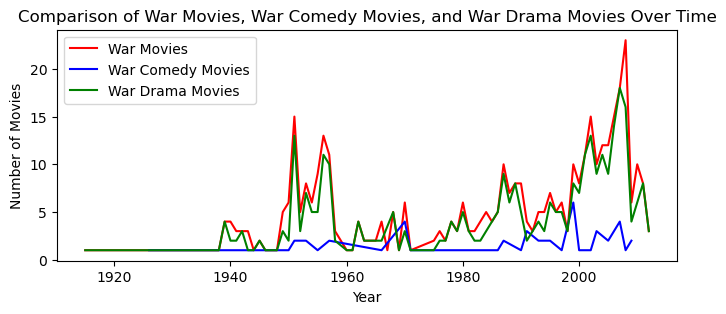

In [152]:
plt.figure(figsize=(8, 3))

# Count the number of movies in each category per year
war_movies_per_year = War_movies.groupby('Year').size()
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Plot the data
plt.plot(war_movies_per_year.index, war_movies_per_year.values, label='War Movies', color='red')
plt.plot(war_comedy_movies_per_year.index, war_comedy_movies_per_year.values, label='War Comedy Movies', color='blue')
plt.plot(war_drama_movies_per_year.index, war_drama_movies_per_year.values, label='War Drama Movies', color='green')

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Comparison of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend()
plt.show()



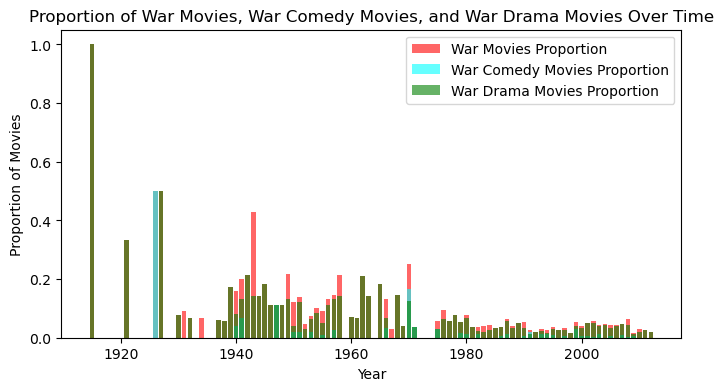

In [153]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

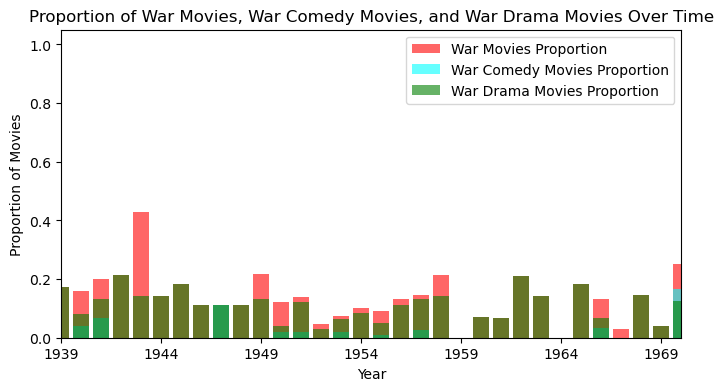

In [154]:
plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.xlim(1939, 1970)
plt.xticks(np.arange(1939, 1971, 5))
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

## fin mini war movie analysis youhouu


Enfin, on veut clean notre dataset additionnel, création de catégories utiles pour l’analyse, comme « guerre », « crise économique », « période de stabilité ». On cherche encore ici à vectoriser et mettre sous forme de token certains types de mots en identifiant les catégories qui nous intéressent.
On veut éliminer les valeurs manquantes ainsi que les événements historiques beaucoup trop vieux pour notre analyse.
Peu importe la méthode utilisée pour tokeniser/vectroriser, expliquer ici pourquoi c'est approprié pour nos objectif et donner une  brève explication mathématique si possible.
On veut aussi transformer les formats de dates pour l’analyse temporelle à l'image de notre movie dataset.

In [155]:
from tests.test_data_preprocessing import test_cleaned_historical_data, test_vectorized_historical_data
import pandas as pd

history_data = pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
history_data.head()

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed
3,7,Battle of Panipat,21,April,1526,India,Battle,Panipat,Foundation of the Mughal Empire in India,Northern Indian kingdoms,Babur,Mixed
4,8,Establishment of British Raj,1,May,1858,India,Colonial,Whole India,Start of direct British governance in India,Indian subcontinent,British East India Company/Empire,Negative


In [156]:
len(history_data)

1096

We can now open the preprocessed dataset, ready for analysis. 
Here are the different steps followed for the preprocessing:

The columns "Place Name","Date" and "Month" were removed. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries. 

Then, we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time. The historical dataset starts from very ancient times, so we only kept relevant events, hence happening after the first movie was released. 

At the end, a new csv file containing the cleaned data was created, in the file preprocessed_history.csv

In [157]:
preprocessed_history = pd.read_csv("data\Preprocessed_data\preprocessed_history.csv")
preprocessed_history.head()

,Sl. No,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,9,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
1,10,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative
2,11,PokhranUnknownII Nuclear Tests,1998,India,Nuclear Test,India declared itself a nuclear state,International community,Atal Bihari Vajpayee,Mixed
3,12,Mumbai Terror Attacks,2008,India,Terrorism,Highlighted the threat of international terrorism,Citizens of Mumbai,LashkarUnknowneUnknownTaiba,Negative
4,16,Swadeshi Movement,1905,India,National Movement,Promoted Indian goods; protest against British...,Indian nationalists,Indian National Congress,Positive


In [158]:
len(preprocessed_history)

803

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)


In [159]:
# Appels au méthodes de plot dans analysis dans src apres nettoyage.